In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors


In [2]:

def _corr_integral(U, eps):
    """
    Correlation integral C_U(eps) = P(||U_i - U_j||_∞ <= eps) over i != j
    Computed via radius-neighbor counts; counts each unordered pair once.
    """
    n = U.shape[0]
    nn = NearestNeighbors(radius=eps, metric="chebyshev", algorithm="kd_tree")
    nn.fit(U)
    # For each i, indices of neighbors within eps (includes i itself)
    ind = nn.radius_neighbors(return_distance=False)
    # total unordered pairs within eps:
    # sum_i (deg_i - 1) counts ordered pairs; divide by 2 to make unordered.
    tot_pairs = sum(len(ix) - 1 for ix in ind) / 2.0
    all_pairs = n * (n - 1) / 2.0
    return tot_pairs / all_pairs


In [3]:

def _standardize(A):
    mu = np.nanmean(A, axis=0)
    sd = np.nanstd(A, axis=0, ddof=0)
    sd[sd == 0] = 1.0
    return (A - mu) / sd


In [4]:

def make_lagged(y, x, lags_y=1, lags_x=1):
    """
    Build (X_t lags), (Y_t lags) and Z_t = y_{t+1}.
    Returns aligned matrices (X, Y, Z) with same length.
    """
    df = pd.DataFrame({"y": y, "x": x}).dropna().reset_index(drop=True)
    for l in range(1, lags_y+1):
        df[f"y_l{l}"] = df["y"].shift(l)
    for l in range(1, lags_x+1):
        df[f"x_l{l}"] = df["x"].shift(l)
    df["z"] = df["y"].shift(-1)  # target at t+1
    df = df.dropna().reset_index(drop=True)

    Y = df[[f"y_l{l}" for l in range(1, lags_y+1)]].values
    X = df[[f"x_l{l}" for l in range(1, lags_x+1)]].values
    Z = df[["z"]].values
    return X, Y, Z, df.index.values  # keep index mapping if needed


In [5]:

def dp_statistic(X, Y, Z, eps):
    """
    DP-style global correlation-integral version:
    T = C_{XYZ} * C_{Y} - C_{XY} * C_{YZ}
    Positive T indicates dependence of Z on X conditional on Y.
    """
    # standardize each block to avoid scaling issues
    Xs = _standardize(X)
    Ys = _standardize(Y)
    Zs = _standardize(Z)

    C_y   = _corr_integral(Ys, eps)
    C_xy  = _corr_integral(np.c_[Xs, Ys], eps)
    C_yz  = _corr_integral(np.c_[Ys, Zs], eps)
    C_xyz = _corr_integral(np.c_[Xs, Ys, Zs], eps)
    T = (C_xyz * C_y) - (C_xy * C_yz)
    return T, {"C_y": C_y, "C_xy": C_xy, "C_yz": C_yz, "C_xyz": C_xyz}


In [6]:

def dp_test(y, x, lags_y=1, lags_x=1, C=1.0, beta=2/7, B=499, block_perm=False, block_len=25, random_state=0):
    """
    Diks–Panchenko nonlinear GC test: X -> Y
    Returns DP statistic and permutation p-value.
    y: target series (e.g., volume)
    x: predictor series (e.g., VIX)
    """
    rng = np.random.default_rng(random_state)
    X, Y, Z, idx = make_lagged(y, x, lags_y=lags_y, lags_x=lags_x)
    n = X.shape[0]
    eps = C * (n ** (-beta))  # shrinking bandwidth

    T_obs, comps = dp_statistic(X, Y, Z, eps)

    # Permutation null: break directional link by permuting X (keeping its lag-structure intact)
    # Option A: simple row permutation (fast); Option B: block permutation (preserve autocorr better).
    def permute_X(X):
        if not block_perm:
            perm_idx = rng.permutation(n)
            return X[perm_idx]
        # block-wise permutation
        blocks = [X[i:i+block_len] for i in range(0, n, block_len)]
        rng.shuffle(blocks)
        return np.vstack(blocks)[:n]

    T_null = np.empty(B)
    for b in range(B):
        Xb = permute_X(X)
        T_null[b], _ = dp_statistic(Xb, Y, Z, eps)

    # Right-tail p-value: large positive T implies reject H0 (no causality)
    pval = (1 + np.sum(T_null >= T_obs)) / (B + 1)
    return {
        "T_obs": T_obs,
        "p_value": float(pval),
        "eps": float(eps),
        "n": int(n),
        "lags_y": lags_y,
        "lags_x": lags_x,
        "C": C,
        "beta": beta,
        "components": comps,
        "T_null_mean": float(T_null.mean()),
        "T_null_std": float(T_null.std(ddof=1)),
    }


In [13]:
df = pd.read_csv("volume_vix_merged.csv", parse_dates=["date"])

In [14]:
lags = [1, 2, 3, 4, 5]
C_values = [0.5, 1.0, 1.5, 2.0]

# Empty list to store results
results = []

print("Running nonlinear Granger causality tests (Diks–Panchenko)...\n")

for lag in lags:
    for C in C_values:
        print(f"Testing lag={lag}, C={C}...")
        res = dp_test(
            y=df["target_volume"].values,
            x=df["vix_close"].values,
            lags_y=lag,
            lags_x=lag,
            C=C,
            beta=2/7,
            B=999,           
            block_perm=True,
            block_len=25,
            random_state=42
        )
        results.append({
            "lags": lag,
            "C": C,
            "T_stat": res["T_obs"],
            "p_value": res["p_value"],
            "eps": res["eps"],
            "n": res["n"]
        })


Running nonlinear Granger causality tests (Diks–Panchenko)...

Testing lag=1, C=0.5...
Testing lag=1, C=1.0...
Testing lag=1, C=1.5...
Testing lag=1, C=2.0...
Testing lag=2, C=0.5...
Testing lag=2, C=1.0...
Testing lag=2, C=1.5...
Testing lag=2, C=2.0...
Testing lag=3, C=0.5...
Testing lag=3, C=1.0...
Testing lag=3, C=1.5...
Testing lag=3, C=2.0...
Testing lag=4, C=0.5...
Testing lag=4, C=1.0...
Testing lag=4, C=1.5...
Testing lag=4, C=2.0...
Testing lag=5, C=0.5...
Testing lag=5, C=1.0...
Testing lag=5, C=1.5...
Testing lag=5, C=2.0...


In [15]:

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Sort nicely
df_results = df_results.sort_values(["lags", "C"]).reset_index(drop=True)


In [16]:

# Round for readability
df_results_rounded = df_results.copy()
df_results_rounded["T_stat"] = df_results_rounded["T_stat"].map("{:.3e}".format)
df_results_rounded["p_value"] = df_results_rounded["p_value"].map("{:.6f}".format)
df_results_rounded["eps"] = df_results_rounded["eps"].map("{:.4f}".format)

# Display summary
print("\n=== Nonlinear Granger Causality: VIX → Volume ===")
print(df_results_rounded.to_string(index=False))


=== Nonlinear Granger Causality: VIX → Volume ===
 lags   C     T_stat  p_value    eps    n
    1 0.5 -4.495e-06 0.001000 0.0432 5282
    1 1.0  6.061e-07 0.001000 0.0864 5282
    1 1.5  3.582e-05 0.001000 0.1295 5282
    1 2.0  1.220e-04 0.001000 0.1727 5282
    2 0.5 -4.681e-07 0.005000 0.0432 5281
    2 1.0 -1.368e-06 0.001000 0.0864 5281
    2 1.5 -3.100e-07 0.001000 0.1296 5281
    2 2.0  8.189e-06 0.001000 0.1727 5281
    3 0.5 -4.721e-08 0.001000 0.0432 5280
    3 1.0 -3.054e-07 0.001000 0.0864 5280
    3 1.5 -6.587e-07 0.001000 0.1296 5280
    3 2.0  3.618e-08 0.001000 0.1728 5280
    4 0.5 -5.032e-09 0.381000 0.0432 5279
    4 1.0 -6.300e-08 0.001000 0.0864 5279
    4 1.5 -2.362e-07 0.001000 0.1296 5279
    4 2.0 -3.413e-07 0.001000 0.1728 5279
    5 0.5 -5.851e-10 1.000000 0.0432 5278
    5 1.0 -1.453e-08 0.001000 0.0864 5278
    5 1.5 -7.999e-08 0.001000 0.1296 5278
    5 2.0 -2.019e-07 0.001000 0.1728 5278


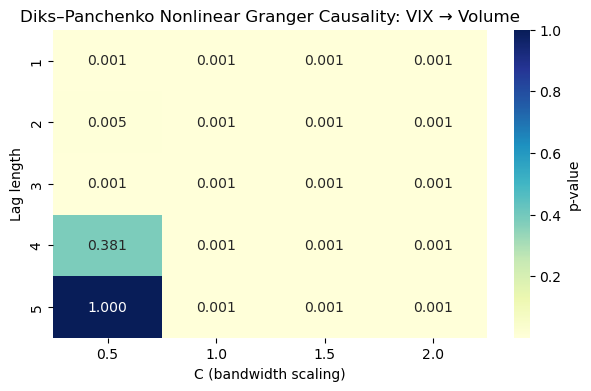

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
pivot = df_results.pivot(index="lags", columns="C", values="p_value")
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".3f", cbar_kws={'label': 'p-value'})
plt.title("Diks–Panchenko Nonlinear Granger Causality: VIX → Volume")
plt.xlabel("C (bandwidth scaling)")
plt.ylabel("Lag length")
plt.show()
